In [4]:
import sys
sys.path.append("../../")
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
import seaborn as sns
from low_dim.fastfood import FastfoodWrapper
from simulations.dim_complexity.train_models import target_function, low_dims, SimModel

style = sns.set(
    style="ticks",
    context="paper",
    rc={
        "font.size": 6,
        "axes.titlesize": 7,
        "axes.labelsize": 7,
        "axes.labelpad": 2,
        "xtick.labelsize": 5,
        "ytick.labelsize": 5,
        "legend.title_fontsize": 5.5,
        "legend.fontsize": 5.5,
        "legend.markerscale": 0.5,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 0.4,
        "xtick.major.width": 0.4,
        "ytick.major.width": 0.4,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,
        "xtick.minor.size": 1.5,
        "ytick.minor.size": 1.5,
        "xtick.minor.width": 0.2,
        "ytick.minor.width": 0.2,
        "figure.constrained_layout.use": True,
        "figure.dpi": 200,
    },
)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def model_predictions(func: int | None, dim: int | None) -> tuple[np.ndarray, np.ndarray]:
    if func is None:
        model = target_function
    else:
        model = SimModel().eval().to(device)
        if dim is None:
            state_dict = torch.load(f"saved_models/func={func}.pth")
        else:
            state_dict = torch.load(f"saved_models/dim={dim},func={func}.pth")
            model = FastfoodWrapper(model, low_dims[dim], model.layer_groups)
        model.load_state_dict(state_dict)
    
    x = np.linspace(-1, 1, 100)
    x_tensor = torch.from_numpy(x).float().to(device)
    with torch.no_grad():
        y = model(x_tensor.unsqueeze(1)).squeeze(1)
    y = y.detach().cpu().numpy()

    return x, y


def plot_model(func, dim, ax: plt.Axes, **kwargs) -> None:
    x, y = model_predictions(func, dim)
    sns.lineplot(x=x, y=y, ax=ax, **kwargs)

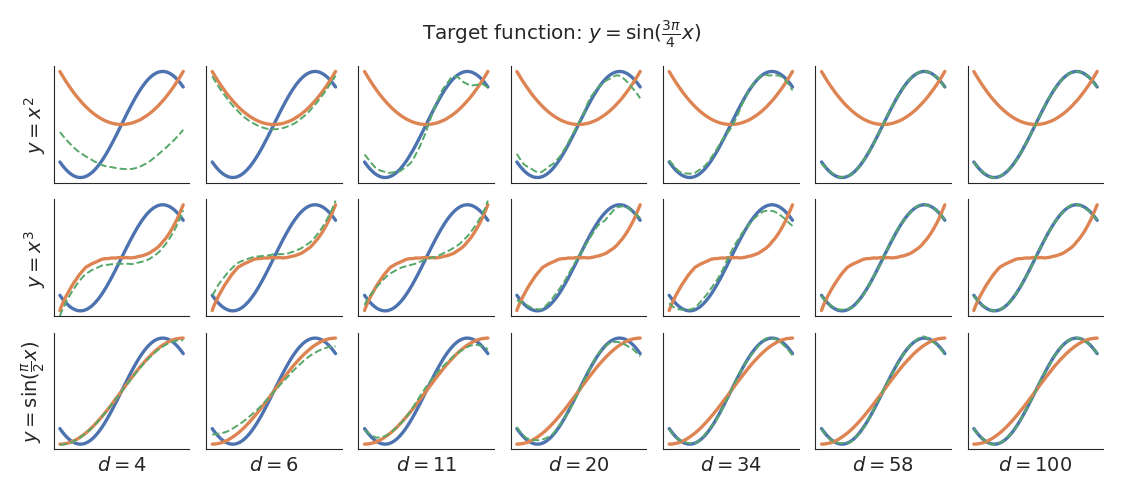

In [6]:
fig, axs = plt.subplots(3, len(low_dims), 
                        figsize=(5.5, 3 * 5.5 / len(low_dims)))

palette = sns.color_palette()

for func in range(axs.shape[0]):
    for dim in range(axs.shape[1]):
        ax = axs[func, dim]

        plot_model(None, None, ax=ax, color=palette[0])
        plot_model(func, None, ax=ax, color=palette[1])
    
        plot_model(func, dim, ax=ax, color=palette[2], 
                   linewidth=0.7, linestyle="--")

fig.suptitle(r"Target function: $y = \sin (\frac{3\pi}{4} x )$")
axs[0, 0].set(ylabel=r"$y = x^2$")
axs[1, 0].set(ylabel=r"$y = x^3$")
axs[2, 0].set(ylabel=r"$y = \sin (\frac{\pi}{2} x )$")
for dim in range(len(low_dims)):
    axs[-1, dim].set(xlabel=f"$d = {low_dims[dim]}$")
for ax in axs.flatten():
    ax.set(xlim=(-1.1, 1.1), ylim=(-1.1, 1.1))
    ax.tick_params(axis="both", which="both", 
                bottom=False, left=False, 
                labelbottom=False, labelleft=False)

plt.savefig("saved_figures/dim_complexity_simulation.jpg", dpi=300)
plt.show()